# Compare Sentinel-2 Cloud probability from Google Earth Engine (GEE) with FMASK from Geoscience Australia (GA) <img align="right" src="../Supplementary_data/dea_logo.jpg">
* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_s2a_ard_nbar_granule](https://explorer.sandbox.dea.ga.gov.au/ga_s2a_ard_nbar_granule)
[ga_s2b_ard_nbar_granule](https://explorer.sandbox.dea.ga.gov.au/ga_s2b_ard_nbar_granule)
[COPERNICUS_S2_CLOUD_PROBABILITY](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY)

## Background
GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, climate data, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog) which can be combined with data from DEA. 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb
- GEE developer guide for working with the S-2 cloud probability layer https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

>**Note**: You will need a Google Earth Engine account subject to their terms and conditions (https://earthengine.google.com/terms/). [Sign up here.](https://signup.earthengine.google.com/)

This notebook is based on: https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

## Description
This notebook demonstrates how to access Sentinel-2 Cloudless cloudmask, create a cloud shadow mask, load GEE and WMS layers within folium and finally load GEE image into numpy array to compare with DEA data.

1. Install GEE API
2. Load python packages
3. Connect to datacube
4. Connect to GEE API
5. Set our Area of interest and thresholds for Sen2Cloudless
6. Create combined Cloud and Shadow mask from Sen2Cloudless within GEE
7. Observe behavior of these cloud masks in comparison with DEA FMASK data
6. Convert GEE image to numpy array
7. Load GA image

***


### Install GEE API and GEEHydro for folium integration

In [1]:
!pip install earthengine-api
!pip install geehydro

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Load packages
Import Python packages that are used for the analysis.

In [2]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube
import geehydro
from functools import partial
from branca.element import Figure
from gee_sen2cloudless_utils import get_s2_sr_cld_col, add_cld_shdw_mask

sys.path.append("../Scripts")
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='cloud_prb_comparison')

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Assemble cloud mask components

This section builds an S2 SR collection and defines functions to add cloud and cloud shadow component layers to each image in the collection.

### Define collection filter and cloud mask parameters

Define parameters that are used to filter the S2 image collection and determine cloud and cloud shadow identification.

|Parameter | Type | Description |
| :-- | :-- | :-- |
| `central_lon` | float | Decimal longitude of area of interest |
| `central_lat` | float | Decimal latitude of area of interest |
| `start_date` | string | Image collection start date (inclusive) |
| `end_date` | string | Image collection end date (exclusive) |
| `cld_prb_thresh` | integer | Cloud probability (%); values greater than are considered cloud |
| `nir_drk_thresh` | float | Near-infrared reflectance; values less than are considered potential cloud shadow |
| `cld_prj_dist` | float | Maximum distance (km) to search for cloud shadows from cloud edges |
| `cloud_buffer` | integer | Distance (m) to dilate the edge of cloud-identified objects |
| `sample_buffer` | float | Buffer to use with GEE .sampleRectangle function. Must be relatively small as this has a cap of how many pixels it will return
| `map_buffer` | float | buffer size for displaying data from datacube oon map = adjust to your available RAM, data and patience


In [5]:
central_lon=152.30192184447827
central_lat=-28.268252634577337

start_date = '2020-12-05'
end_date = '2020-12-06'

cld_prb_thresh = 50
nir_drk_thresh = 0.15
cld_prj_dist =1
cloud_buffer = 50

sample_buffer = 0.02
map_buffer = 0.2

### Compute bounding boxes for our applications

In [6]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - sample_buffer, central_lat + sample_buffer)
study_area_lon = (central_lon - sample_buffer, central_lon + sample_buffer)

# Compute the bounding box for the map area
map_area_lat = (central_lat - map_buffer, central_lat + map_buffer)
map_area_lon = (central_lon - map_buffer, central_lon + map_buffer)

# Define an area of interest polygon for GEE
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

### FMASK specific configuration

In [7]:
sentinel_2_products = ['ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule']
cloud_measurement = "fmask"
de_sentinel_2_layername = "Sentinel-2 FMASK"
wms_url="https://ows.dea.ga.gov.au/wms"
wms_display_name="GA Sentinel-2"
wms_layer="s2_ard_granule_nbar_t"

### Retrieve output_crs and resolution for retrieval from datacube

In [8]:
datasets = dc.find_datasets(product=sentinel_2_products,
              x= study_area_lon,
              y= study_area_lat,
              time=(start_date, end_date))

output_crs = datasets[0].metadata_doc['grid_spatial']['projection']['spatial_reference']

gt = datasets[0].metadata_doc['image']['bands'][cloud_measurement]['info']['geotransform']
resolution = (gt[5],gt[1])

### Load cloud probability layer, then construct cloud and shadow mask with our thresholds

In [9]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(ee, aoi, start_date, end_date)
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(partial(add_cld_shdw_mask, ee, cld_prb_thresh, nir_drk_thresh, cld_prj_dist, cloud_buffer ))

### Plot GEE imagery, cloud probabiliy and cloud mask on a map and compare with DE data

In [10]:
location=[central_lat, central_lon]
zoom_start = 12

# Create a folium map object
my_map = folium.Map(location=location, zoom_start=zoom_start)

# Add our WMS as a refence layer
folium.raster_layers.WmsTileLayer(
    url=wms_url,
    name=wms_display_name,
    fmt="image/png",
    layers=wms_layer,
    style='simple_rgb',
    version='1.3.0',
    time=start_date,
    transparent = True,
).add_to(my_map)


# Mosaic the image collection.
img = s2_sr_cld_col_eval_disp.mosaic()

# Subset layers and prepare them for display.
clouds = img.select('clouds').selfMask()
shadows = img.select('shadows').selfMask()
dark_pixels = img.select('dark_pixels').selfMask()
probability = img.select('probability')
cloudmask = img.select('cloudmask').selfMask()
cloud_transform = img.select('cloud_transform')

# Add layers to the folium map.
my_map.addLayer(img,
               {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
               'S2 image')
my_map.addLayer(probability,
               {'min': 0, 'max': 100},
               'probability (cloud)')
my_map.addLayer(clouds,
               {'palette': 'e056fd'},
               'clouds')
my_map.addLayer(cloud_transform,
               {'min': 0, 'max': 1, 'palette': ['white', 'black']},
               'cloud_transform')
my_map.addLayer(dark_pixels,
               {'palette': 'blue'},
               'dark_pixels')
my_map.addLayer(shadows, {'palette': 'yellow'},
               'shadows')
my_map.addLayer(cloudmask, {'palette': 'orange'},
               'cloudmask')

# load fmask for map in horrible projection
de_s2_cloudmask = dc.load(
          product=sentinel_2_products,
          measurements=[cloud_measurement],
          lon= map_area_lon,
          lat= map_area_lat,
          time=(start_date, end_date),
          output_crs='EPSG:3857',
          resolution=resolution
)

# reshape array for correct display
array = de_s2_cloudmask.isel(time=0).to_array().transpose("y", "x", "variable").values    

folium.raster_layers.ImageOverlay(
    image=array,
    name=de_sentinel_2_layername,
    bounds= [[map_area_lat[0], map_area_lon[0]],[map_area_lat[1], map_area_lon[1]]], 
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=4
).add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

#display folium map without ugly space beneath it
fig = Figure(width=800, height=800)
fig.add_child(my_map)

### Load Combined cloudmask into numpy array

In [11]:
cloudmask = s2_sr_cld_col_eval_disp.select('cloudmask')
imgs = cloudmask.toBands()
bands = imgs.getInfo()['bands']

cloud_np_arrays = []
for band in bands:
    
    gee_image = imgs.select(band['id'])
    
    #need to manually set a unsigned int8 default value, 0 isnt safe so will use 255
    band_arrs = gee_image.sampleRectangle(region=aoi, defaultValue=255)

    band_arr_cloud = band_arrs.get('clouds')
    
    cloud_np_arrays.append((band['id'], np.array(band_arr_cloud.getInfo())))

### Load Digital Earth cloud classification

In [12]:
de_cloud_data = []

for dataset in datasets:
    id = dataset.metadata_doc['id']
    de_cloud_data.append((dataset.metadata_doc['tile_id'],dc.load(
              id=id,
              product=sentinel_2_products,
              x= study_area_lon,
              y= study_area_lat,
              time=(start_date, end_date),
              output_crs=output_crs,
              measurements = [cloud_measurement],
              resolution=resolution
            )))

### Generate some charts

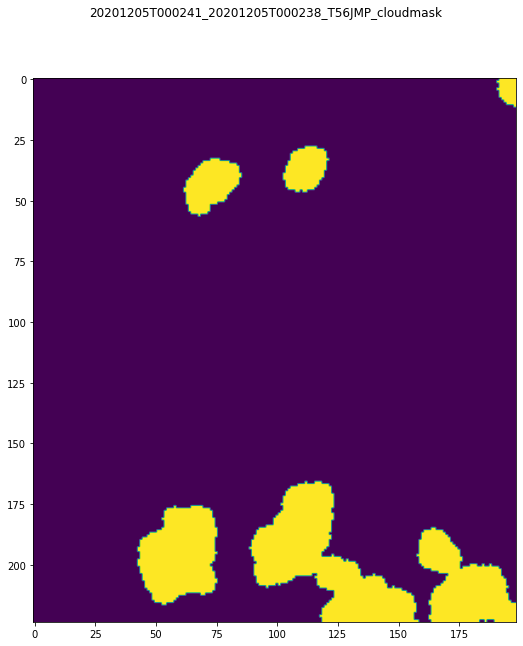

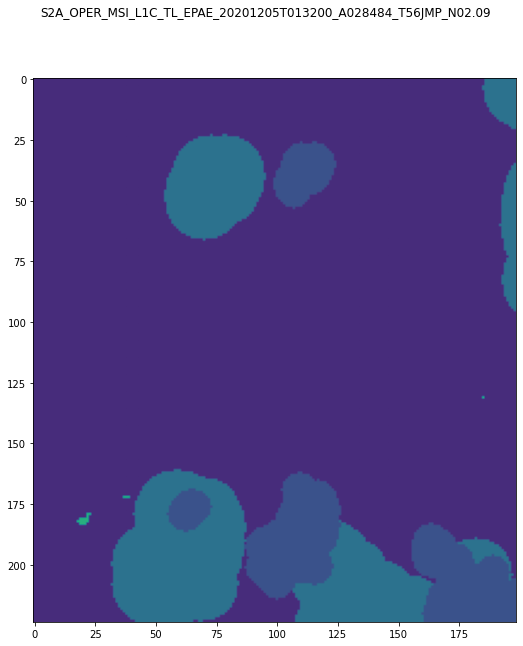

In [13]:
for cloud_np_array in cloud_np_arrays: 
    # Plot array
    plt.figure(figsize=(10, 10))
    #why is this upside down?
    plt.imshow(np.flipud(cloud_np_array[1]), vmin =0, vmax=1)
    plt.suptitle(cloud_np_array[0])
    plt.show()

for de_cloud in de_cloud_data: 
    # Plot array
    plt.figure(figsize=(10, 10))
    plt.imshow(de_cloud[1][cloud_measurement].squeeze(),vmin=0,vmax=8)
    plt.suptitle(de_cloud[0])
    plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2021

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`sentinel 2`, :index:`GEE`, :index:`cloud masking`